In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

#Load Datasets
customers_df = pd.read_csv(r"C:\Users\panch\Downloads\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\panch\Downloads\Transactions.csv")

# Merge data on CustomerID
merged_df = pd.merge(customers_df, transactions_df, on="CustomerID", how="inner")
#display(merged_df)

# Feature engineering: Total value of transactions, Total quantity purchased
customer_summary = merged_df.groupby('CustomerID').agg(
    total_value=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum'),
    avg_value=('TotalValue', 'mean'),
    num_transactions=('TransactionID', 'nunique')
).reset_index()

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_summary[['total_value', 'total_quantity', 'avg_value', 'num_transactions']])



In [25]:
# Try different K values (between 2 and 10)
db_scores = []
inertia_values = []
k_range = range(2, 11)

for k in k_range:
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    
    # Calculate Davies-Bouldin Index for evaluation
    db_score = davies_bouldin_score(scaled_features, kmeans.labels_)
    db_scores.append(db_score)
    
    # Save inertia (sum of squared distances) to plot Elbow Method
    inertia_values.append(kmeans.inertia_)

# Find the optimal number of clusters based on Davies-Bouldin index (lowest score is better)
optimal_k = k_range[np.argmin(db_scores)]

# Train the KMeans model with the optimal K
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_kmeans.fit(scaled_features)
customer_summary['Cluster'] = final_kmeans.labels_

# Print the optimal K value and its Davies-Bouldin score
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {min(db_scores)}")




C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

Optimal number of clusters: 7
Davies-Bouldin Index: 0.8758128083782715


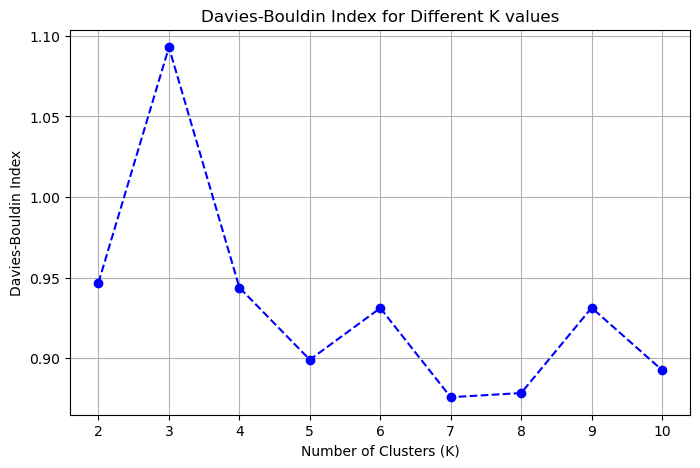

In [26]:
# Plot Davies-Bouldin Index vs. number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker='o', linestyle='--', color='b', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Different K values')
plt.grid(True)
plt.show()

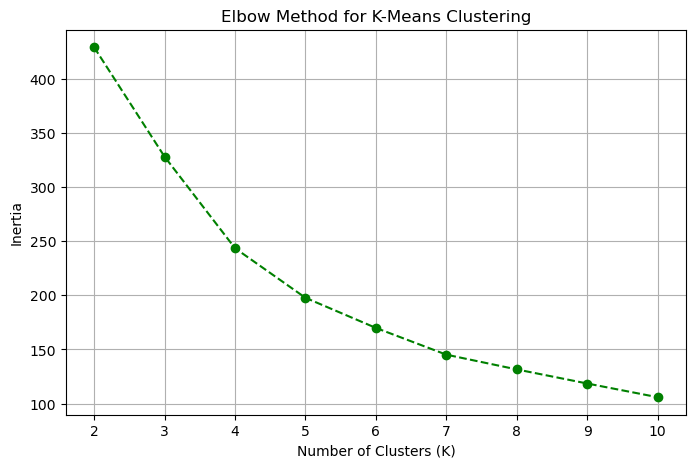

In [27]:
# Elbow method (inertia vs. number of clusters)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia_values, marker='o', linestyle='--', color='g', label='Inertia')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means Clustering')
plt.grid(True)
plt.show()

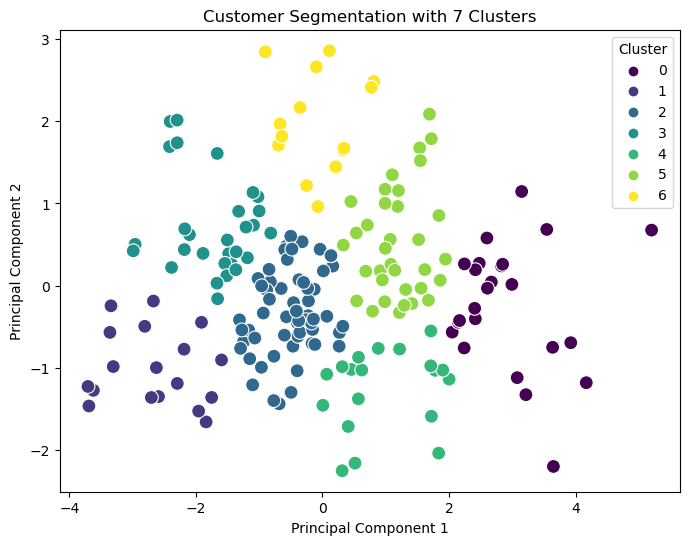

In [28]:
# Visualizing the clusters using PCA for 2D representation
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=customer_summary['Cluster'], palette='viridis', s=100)
plt.title(f"Customer Segmentation with {optimal_k} Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()